#### Importamos librerías con las que trabajaremos

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [70]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio import mask

#### Descargamos fichero shp Región Metropolitana

In [3]:
rm_comunas = gpd.read_file('C:/Users/Pablo/GeoPython/Chile/Censo/R13/COMUNA_C17.shp')

In [4]:
# proyectamos coordenadas
rm_comunas.to_crs(4326, inplace=True)

#### AOI Región Metropolitana

In [6]:
rm_aoi = rm_comunas.dissolve()

#### Descargamos las estaciones de metro de la red de Santiago

In [9]:
tags_stations = {'railway':'station'}

In [10]:
pois_stations = ox.geometries.geometries_from_polygon(polygon = rm_aoi.iloc[0]['geometry'], tags=tags_stations)

In [31]:
metro_stations = pois_stations.loc[pois_stations.station=='subway']

#### Creamos buffer de 1km de las estaciones de metro

In [38]:
buffer_stations = metro_stations.to_crs({'init': 'epsg:9155'})  
buffer_stations['geometry'] = buffer_stations.geometry.buffer(1000)

C:\Users\Pablo\pyproj\my_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


#### Mapa

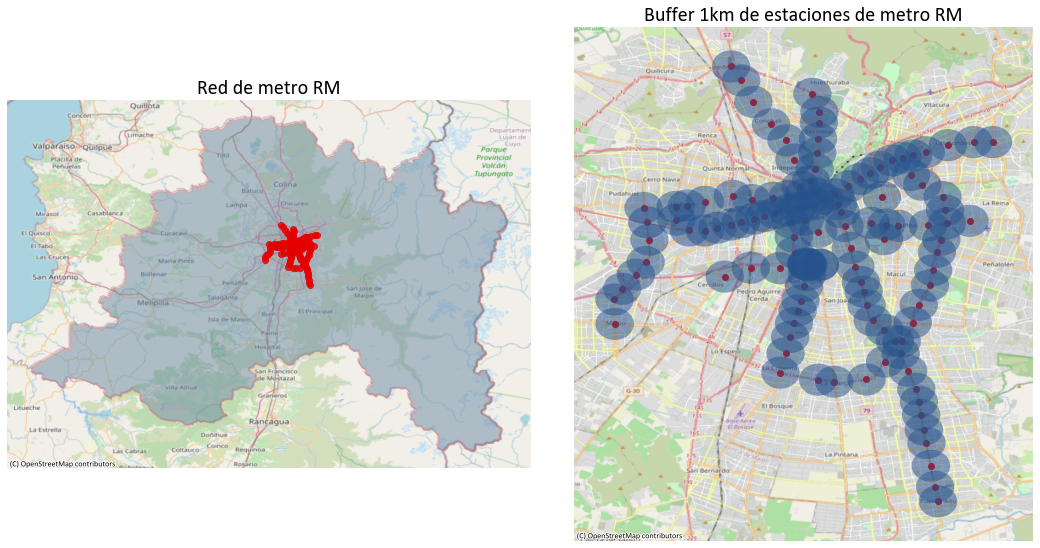

In [119]:
fig = plt.figure(figsize=(15,15))
plt.rcParams["font.family"] = "calibri"
plt.rc('legend',fontsize=12)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)

rm_aoi.plot(linewidth=1.1, facecolor='xkcd:grey blue', edgecolor='xkcd:salmon', ax=ax1, alpha=0.5)
pois_stations.loc[pois_stations.station=='subway'].plot(ax=ax1, color='#e50000', alpha=0.8)
cx.add_basemap(ax1, crs=rm_aoi.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax1.set_title('Red de metro RM', fontsize=20)
ax1.set_axis_off()
pois_stations.loc[pois_stations.station=='subway'].plot(ax=ax2, color='#e50000', alpha=1)
buffer_stations.to_crs(4326).plot(ax=ax2, color='#26538d', alpha=0.5)
cx.add_basemap(ax2, crs=rm_aoi.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax2.set_title('Buffer 1km de estaciones de metro RM', fontsize=20)
ax2.set_axis_off()
plt.tight_layout()
fig.savefig('grafico_accesibilidad.png', dpi=400, bbox_inches='tight')

#### Abrimos archivo raster obtenido de WorldPop

In [85]:
chile_pop_fp = 'chl_ppp_2020_UNadj_constrained.tif'

In [86]:
chile_pop = rasterio.open(chile_pop_fp)

#### Población RM

In [90]:
gtraster, bound = mask.mask(chile_pop, rm_aoi.geometry, crop=True)

In [91]:
rm_pop = gtraster[0][gtraster[0]>0].sum()
rm_pop

7997701.0

#### Población Buffers

In [92]:
gtraster2, bound2 = mask.mask(chile_pop, buffer_stations.to_crs(4326).geometry, crop=True)

In [93]:
buffer_metro_pop = gtraster2[0][gtraster2[0]>0].sum()
buffer_metro_pop

1961426.1

#### Porcentaje Población Buffers sobre Pop Total

In [121]:
percentage_pop = (buffer_metro_pop/rm_pop*100).round(1)
percentage_pop

24.5